# Time Series Testing

## Evaluating and Testing Forecasting Models

### Setup

* Imports and formatting dataset

In [1]:
import re
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.api import tsa
from statsmodels.tsa.ar_model import ar_select_order
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline

In [2]:
# Import the data
full_df = pd.read_csv("data/MonthlySales.csv")

# Here we have monthly sales data for a company.
# We will focus solely on the revenue and explore if we can model the company revenue using time series.
# Convert the revenue to be on a scale of millions for readability.
full_df.loc[:, "Revenue"] = full_df.loc[:, "Revenue"].apply(lambda x: x / 1e6)
# Select a subsection
df = full_df.loc[:, ["Period", "Revenue"]]
# Drop any NaN values
df.dropna(inplace=True)

# Convert the data to have datetime indices with frequencey of month start
df.set_index("Period", inplace=True)
df.index = pd.to_datetime(df.index, format="%d.%m.%Y")
df.index.freq = "MS"

time_series = df.diff(1).dropna()
time_series.head()

,Revenue
Period,
2015-02-01,-0.202485
2015-03-01,6.239559
2015-04-01,-3.232563
2015-05-01,-4.793104
2015-06-01,2.762449


# Testing for forecasting models

As with any machine learning (ML) model, it is important to evaulate and assess the fit and the performance. 

This notebook will involve loading some data and exploring how to assess a forecasting model, use it to fit a time series model and fundamentally test the performance of forecasts. 

We will explore ideas that are familiar from previously covered ML models including **residual diagnostics**, **train/test splits** and **cross validation**.

### Residuals

Residuals in general refer to what is **'left over'** and so residuals of a model are given by the difference between the raw observations (i.e. our data) and the corresponding fitted values.

$e_t=y_t−\hat{y}_t$

We have seen previously that when tuning and selecting a time series model, we can use the mean absolute error as a metric. We will now look at how else you can use the residuals.

### Analysing the residuals 

The residuals allow us to confirm if a time series model has captured the data adequately by using the following checks:

A good forecasting method will have:

  1) **Uncorrelated residuals**, as if there's a strong relationship between residuals then more information can be used from them to compute forecasts.

  2) **Zero mean residuals**, as otherwise the forecasts are biased.
  
This is not to say that if these conditions are satisfied then we can't improve our model, however it is an important step to checking our model choice.

Residuals are a concept which are commonly used when fitting and evaluating regression models, with the simplest example being linear regression. Considering the residuals, or errors, can also apply to time series and be a very useful method for checking if a model has captured the data well. 

In particular, each observation in a time series can be forecast using all previous observations. These fitted values are not true forecasts because the parameters are estimated using all available data, however they allow us to compute the residuals and assess our model. 

The mean absolute error of the residuals is one choice of model evaluation, however we can also check that these residuals have features of a good forecasting model and inform us of how to make changes. 

The main features to check for are that the residuals are uncorrelated and have zero mean. We will now explore how to test this.

Extra note:

In the case that we have non-zero mean residuals, we can simply add the mean of the residuals to our estimates to unbias the forecasts. Handling correlated residuals is harder to do but further information on this can be found in Chapter 9 of the book given here: https://otexts.com/fpp2/residuals.html.


## Fitting an AR model 

We can fit an AR model to our revenue data using lags selected to optimise the AIC. 

Optimal p = 9


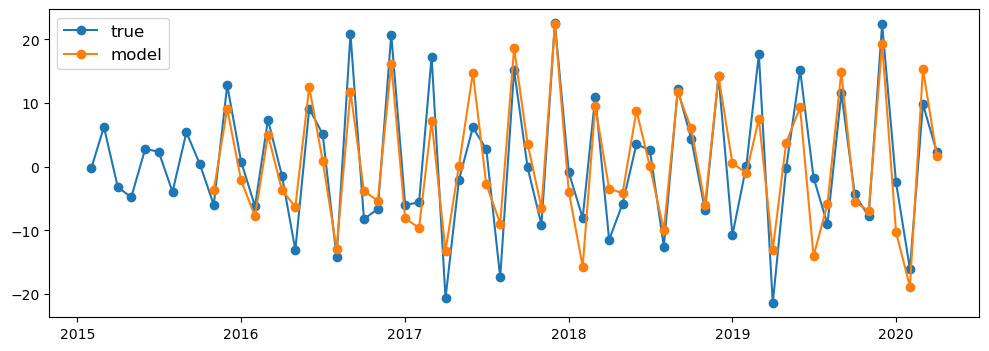

In [3]:
from statsmodels.tsa.ar_model import ar_select_order

mod = ar_select_order(time_series, maxlag=10, ic="aic")
optlag = max(mod.ar_lags)
print("Optimal p =", optlag)

ar = tsa.AutoReg(time_series, lags=optlag)
ar_result = ar.fit()
prediction = ar_result.predict(start=optlag)

plt.figure(figsize=(12, 4))
plt.plot(time_series, "-o", label="true")
plt.plot(prediction, "-o", label="model")
plt.legend(fontsize=12)

## Assessing Residual Diagnostics

We can compute the residuals and see how close the mean residual is to zero. Further, to check that the residuals are uncorrelated we can check that the autocorrelation is zero for all lags other than zero.

In [4]:
fit_residuals = time_series[optlag:].values.flatten() - prediction

The mean residual value is:  3.782982157982015e-16


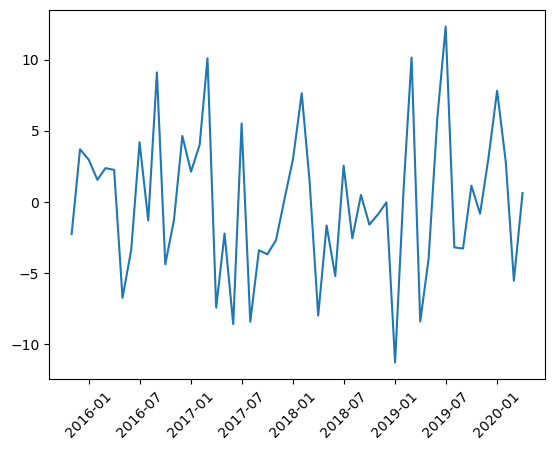

In [5]:
print("The mean residual value is: ", np.mean(fit_residuals))
# Plot the result
plt.plot(fit_residuals)
plt.xticks(rotation=45)
plt.show()

Firstly we compute the residuals and plot them. We can see that the osciallate around zero which is what we want. We can also confirm that the mean value is extremely close to zero and therefore we do not need to add anything to our estimates to unbias the forecasts. 

### Checking for uncorrelated residuals

We can plot the autocorrelation using the `plot_acf` function.

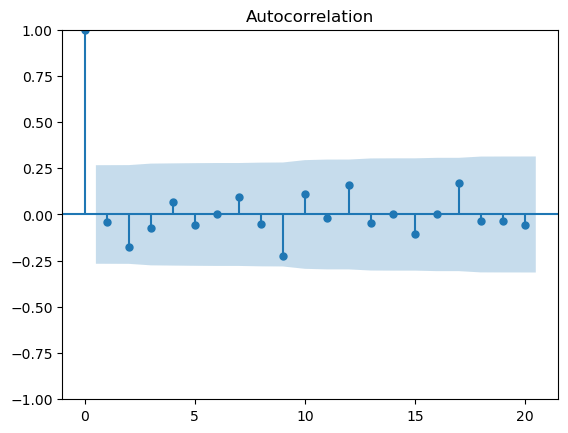

In [6]:
plot_acf(fit_residuals, lags=20)
plt.show()

The autocorrelation function checks for internal correlation of a series with lagged versions of itself. In order for the residuals to be uncorrelated we need to see that there is no lag for which we have significant correlation. 

The `plot_acf` function plots a blue 'corridor' which indicates the region of non significant correlation. As all our values are within this blue shaded region for all lags, we can say that our lags are uncorrelated. 

Extra: If the variance of the residuals is not constant, we say that heteroscedasticy exists.

- Another useful test of autocorrelation in the residuals is the **Breusch-Godfrey test**

- It is used to test the hypothesis that there is no autocorrelation in the residuals up to a certain specified order. 

- A small p-value indicates there is significant autocorrelation remaining in the residuals.

- Extra: The Breusch-Godfrey test is similar to the Ljung-Box test, but it is specifically designed for use with regression models.

## Additional properties

Other properties of the residuals you can explore are that the **variance of the residuals is constant** and that they are **approximately normally distributed**. These indicators are specifically useful for making prediction intervals, that is if you want to make a confidence interval for your forecast.  

This can be done by eye or via statistical tests such as the Shapiro–Wilk test or the Jarque–Bera test.

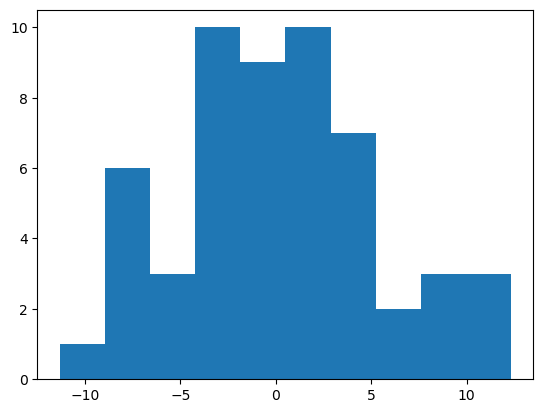

In [7]:
plt.hist(fit_residuals)
plt.show()

Showing the histogram for this dataset the residuals are very roughly normally distributed. The tails seem slightly skewed but we have a fairly symmetric distribution with a clear mean at 0. We can test this formally using the Shapiro test below.

In [8]:
# Use the Shapiro test to assess normality.
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution
from scipy.stats import shapiro

test = shapiro(fit_residuals)
print("The p value is", test.pvalue, "so the data is normal")

The p value is 0.8812108635902405 so the data is normal


### Extra

- Depending on how the parameter estimates are computed, there may be an assumption of normal data. 


- Therefore if the residuals are not normal you can look at the histogram of residuals and consider transformations that may help. 


- A simple go to is to try a log-transform, then re-fit ARIMA and consider the residuals again. 


- In advanced cases, you can consider t-distributed (or non normal) errors.

## Forecasting

- Until now we have tuned the model to *fit* the time series and explore ways to assess the fit of a time series.  This allows us to find a description of the data, but doesn't give forecast.

- It is important to **evaluate forecast accuracy using genuine forecasts** and so we have to use data that was not used to form the model in order to generate a prediction.

- So as with other ML models, we split our time series data into **training and test**, with the test set being in the region of **15-30% of the total sample**, depending on the size of the sample and distance into the future which you would like to predict. 

## Caveat for Time Series Testing 

Testing a standard prediction model can be done in many ways. Usually we don't need to worry about ordering over observations so we can just go ahead and divide or sample our data. 

However, with time-series data we need to **account for the chronological ordering.**

To do this, we must make sure that we only use past observations when making predictions. This is also important to be realistic in a production setting.


Out of sample MAE = 12.697


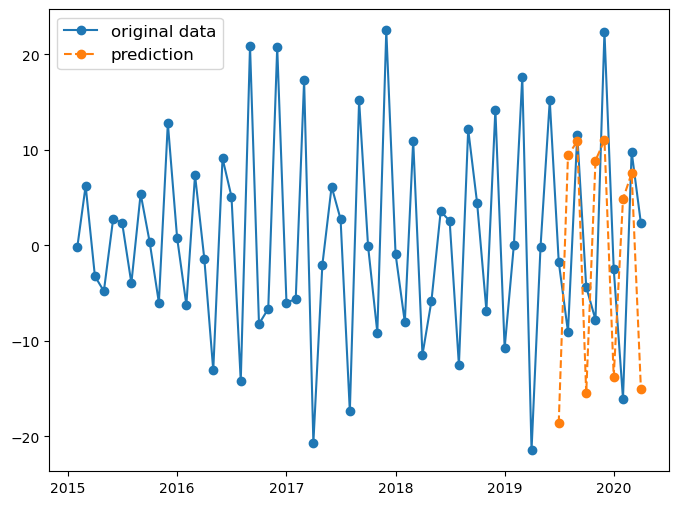

In [9]:
# divide data into training and testing:
train = time_series[:-10]
test = time_series[-10:]

# choose the optimal lag using AIC (this is a model selection criterion) and the training data
mod = ar_select_order(train, maxlag=10, ic="aic")
optlag = max(mod.ar_lags)

# fit our AR model using the tsa module
ar = tsa.AutoReg(train, lags=optlag)

# now we fit our model
arfit = ar.fit()

# we make predictions on unseen data:
prediction = arfit.predict(end=len(time_series) - 1)[-len(test) :]

# produce some figures:
plt.figure(figsize=(8, 6))
plt.plot(time_series, "-o", label="original data")
plt.plot(prediction, "--o", label="prediction")

plt.legend(fontsize=12)

print("Out of sample MAE = {0:.3f}".format(mean_absolute_error(test, prediction)))

### Visualising the forecast 

We can 'zoom in' on the forecast and just have a look at the test data versus the prediction

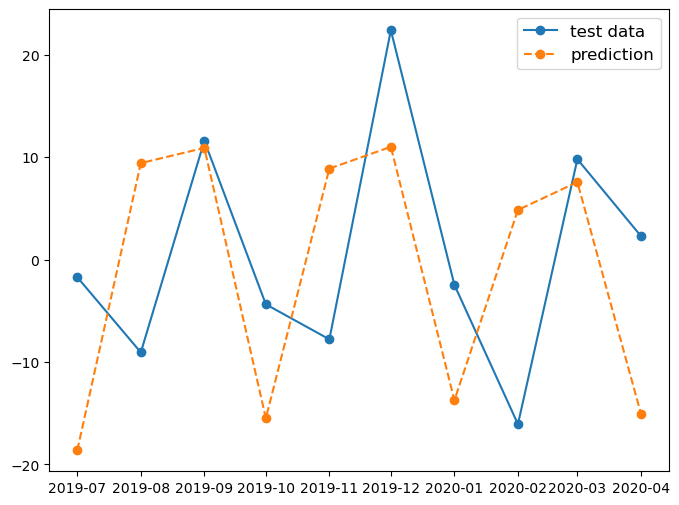

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(test, "-o", label="test data")
plt.plot(prediction, "--o", label="prediction")

plt.legend(fontsize=12)
plt.show()

## Advancing our model: SARIMA

We can add seasonality and stationarity to our ARMA model to produce a model known as 'SARIMA'. 

By optimising the parameters for our training data we can improve of the model accuracy of our previously considered AR model.

Out of sample MAE = 6.228


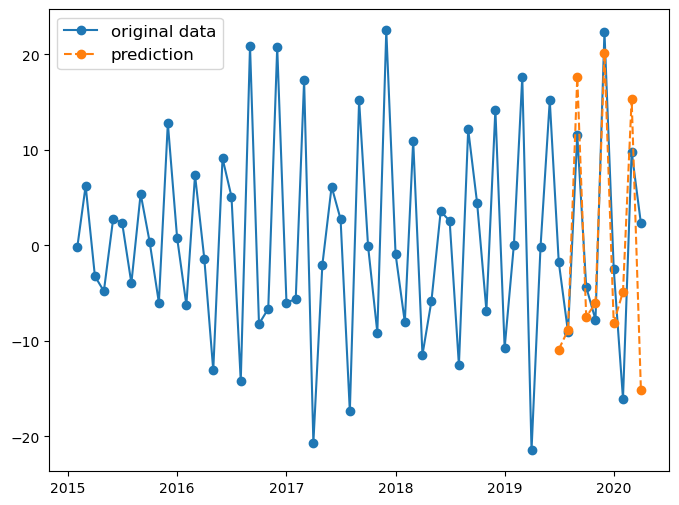

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# divide data into training and testing:
train = time_series[:-10]
test = time_series[-10:]

mod = SARIMAX(
    train,
    trend="c",
    order=(3, 0, 3),
    seasonal_order=(1, 0, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_fit = mod.fit()

# we make predictions on unseen data:
prediction = sarima_fit.predict(end=len(time_series) - 1)[-len(test) :]


# produce some figures:
plt.figure(figsize=(8, 6))
plt.plot(time_series, "-o", label="original data")
plt.plot(prediction, "--o", label="prediction")

plt.legend(fontsize=12)

print("Out of sample MAE = {0:.3f}".format(mean_absolute_error(test, prediction)))


Just plotting the test and prediction region to see the performance more clearly we have the following.

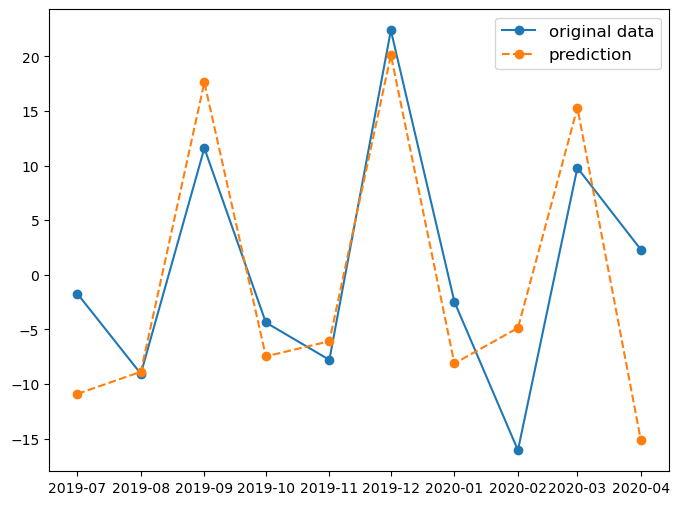

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(test, "-o", label="original data")
plt.plot(prediction, "--o", label="prediction")

plt.legend(fontsize=12)
plt.show()

## Cross-Validation for Time Series Forecasting

- Cross-validation is a way of conducting **repeated training/test splits** in a systematic manner such that each time point is used for test exactly once. 

- In the case of time series data, due to the ordering of time points we have to take care when dividing our data into K folds. Thus, **no future observations can be used in constructing the forecast**.

- In particular, the corresponding training set consists only of observations that occurred prior to test set points.

- Since it is not possible to obtain a reliable forecast based on a small training set, the earliest observations are not considered as test sets.

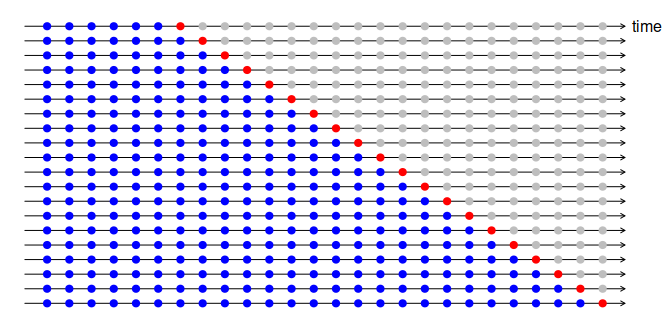

This figure illustrates the concept of cross validation for time series by showing the series of training and test sets, where the blue observations form the training sets, and the red observations form the test sets.

This can be thought of as forward chaining, where your procedure would be something like this:

    fold 1 : training [1], test [2]
    fold 2 : training [1 2], test [3]
    fold 3 : training [1 2 3], test [4]
    fold 4 : training [1 2 3 4], test [5]
    fold 5 : training [1 2 3 4 5], test [6]
    and so on...


The forecast accuracy is computed by averaging over the test sets. 

Extra: This figure shows one-step forecasts, however it is also possible to produce multi-step forecasts. In this case, the cross-validation procedure can be modified to allow us to look multiple steps into the future for our prediction. 

### Extension Topics: Multicolinearity

- Multicolinearity is an issue that can come up in mutlivariate time series analysis. This is when we have multiple time series feeding into the model other than just the history of our target process. 


- If one independent input variable is highly linearly correlated with another input variable, then it is difficult to determine their influences separately. Therefore we can check for high values of correlation between the input variables.


- Solution to the problem is to either (1) combine variables, (2) eliminate one of the variables or (3), possibly increase the sample size. 

### Extension Topics: Residuals for multivariate input

- As mentioned when considering multicolinearity, dealing with multiple input time series can change how we consider testing.


- As in the univariate case (just using the history of the target time series) we explore the variance and mean of the residuals.


- We can also examine scatterplots of the residuals against each of the multiple input variables to look for trends.


- It is also very useful to plot the residuals against any external predictors that are not in the model but are of interest. If any of these show a pattern, then the corresponding predictor may need to be added to the model.